In [2]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd 

In [46]:
fname = join(os.getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)


mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Aug 21 08:47:01 2009',
 '__version__': '1.0',
 '__globals__': [],
 'dataset': array([[[ 3.27506611e+00,  5.56749729e-02, -6.10563983e+00, ...,
           1.52638742e+01, -5.05732129e+00, -2.35653511e+01],
         [ 1.46563935e-01,  1.23448723e-01, -4.24525642e-01, ...,
           6.25273117e-01,  1.85313544e-01, -8.52488431e-02],
         [-1.93246197e-01,  1.94686448e-01,  2.90962808e-01, ...,
          -4.30015321e-01, -6.43310332e-02, -9.70442927e-02],
         [ 6.05183281e-01,  9.76822133e-02, -9.56286861e-02, ...,
           1.99991643e-01, -2.18399824e-01, -1.86841496e-02],
         [-4.87040206e-01, -2.91907644e-01,  6.20977398e-02, ...,
          -3.72035175e-02,  1.16214136e-01, -5.00153914e-02]],
 
        [[ 2.10692524e+01, -2.38783396e+01, -2.98220402e+01, ...,
           1.14053713e+01,  1.12252817e+01, -3.18153171e+01],
         [ 7.92362892e-01,  2.61239752e-01, -5.25031968e-01, ...,
           5.76

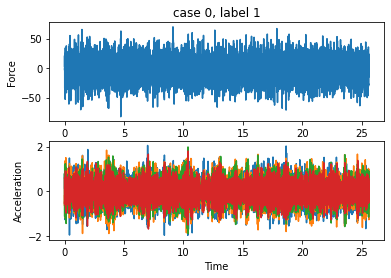

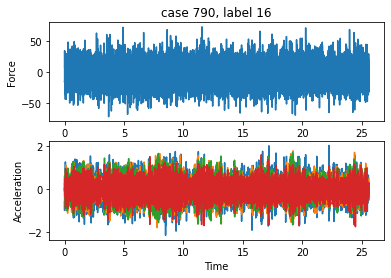

In [47]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()
    


In [5]:
ARmodel_2 = AutoReg(Ch2[:,1],30,old_names=False).fit()
ARmodel_3 = AutoReg(Ch3[:,1],30,old_names=False).fit()
ARmodel_4 = AutoReg(Ch4[:,1],30,old_names=False).fit()
ARmodel_5 = AutoReg(Ch5[:,1],30,old_names=False).fit()
vec_2 = ARmodel_2.params
vec_3 = ARmodel_3.params
vec_4 = ARmodel_4.params
vec_5 = ARmodel_5.params
vec_temp = np.concatenate((vec_2,vec_3,vec_4,vec_5))

ARmodel_var = vec_temp

for i in range(1,850):
    ARmodel_2 = AutoReg(Ch2[:,i],30,old_names=False).fit()
    ARmodel_3 = AutoReg(Ch3[:,i],30,old_names=False).fit()
    ARmodel_4 = AutoReg(Ch4[:,i],30,old_names=False).fit()
    ARmodel_5 = AutoReg(Ch5[:,i],30,old_names=False).fit()
    vec_2 = ARmodel_2.params
    vec_3 = ARmodel_3.params
    vec_4 = ARmodel_4.params
    vec_5 = ARmodel_5.params
    vec_temp = np.concatenate((vec_2,vec_3,vec_4,vec_5))
    ARmodel_var = np.vstack([ARmodel_var,vec_temp])

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


num_components = 0.95 

pca = PCA(n_components=num_components)
data_pca = pca.fit_transform(ARmodel_var)

scaler = MinMaxScaler(feature_range=(-1, 1))

inDam = y > 9
data_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(data_pca)),pd.DataFrame({'target':indDam})],axis=1)

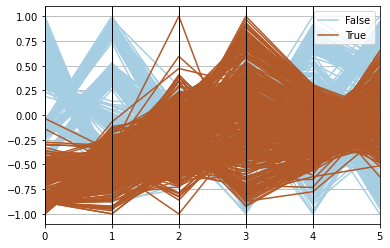

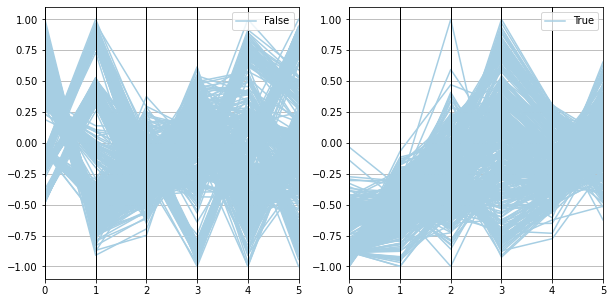

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot all data
plt.figure()
pd.plotting.parallel_coordinates(data_scaled, 'target',colormap=plt.get_cmap('Paired'))
plt.show()

# Create subplots for target class 0 and 1
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
pd.plotting.parallel_coordinates(data_scaled[data_scaled['target'] == 0], 'target', colormap=plt.get_cmap('Paired'))
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
pd.plotting.parallel_coordinates(data_scaled[data_scaled['target'] == 1], 'target', colormap=plt.get_cmap('Paired'))
plt.show()



In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.4, random_state=42)
model1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision X2:", accuracy)

X_train, X_test, y_train, y_test = train_test_split(ARmodel_var, y, test_size=0.4, random_state=42)
model2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision X1:", accuracy)

C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\lxcas\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Précision X2: 0.9205882352941176
Précision X1: 0.9911764705882353


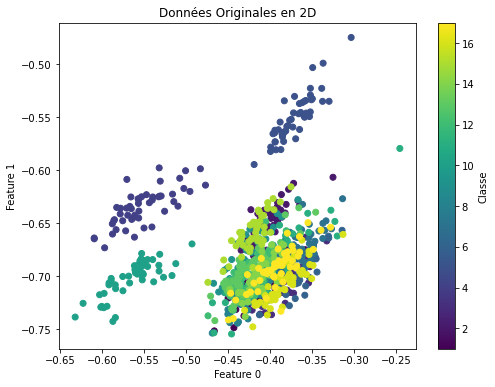

In [56]:
feature1 = 0
feature2 = 1

plt.figure(figsize=(8, 6))
plt.scatter(ARmodel_var[:, feature1], ARmodel_var[:, feature2], c=y, cmap='viridis')
plt.xlabel(f'Feature {feature1}')
plt.ylabel(f'Feature {feature2}')
plt.title('Données Originales en 2D')
plt.colorbar(label='Classe')
plt.show()


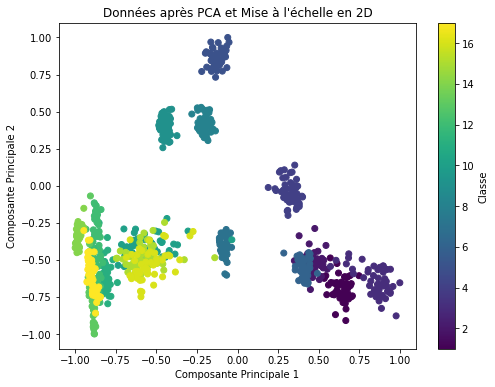

In [24]:
pca_feature1 = 0
pca_feature2 = 1

plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, pca_feature1], data_scaled[:, pca_feature2], c=y, cmap='viridis')
plt.xlabel(f'Composante Principale {pca_feature1 + 1}')
plt.ylabel(f'Composante Principale {pca_feature2 + 1}')
plt.title('Données après PCA et Mise à l\'échelle en 2D')
plt.colorbar(label='Classe')
plt.show()
